In [1]:
import networkx as nx
import numpy as np
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import copy

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Linear Threshold Mode

In [123]:
class linear_threshold():
    def __init__(self):
        self.g = nx.DiGraph()
        self.influence = None
    
    def fit(self, g):
        # fit graph with probability
        in_degree = g.in_degree()
        self.num_nodes = g.number_of_nodes()
        self.node_label = [i for i in g.nodes()]
        max_degree = max([d for (n, d) in in_degree])
        self.label2id = {self.node_label[i]: i for i in range(self.num_nodes)}
        self.influence = np.zeros((self.num_nodes, self.num_nodes), dtype=float)
        # init influence 
        for e in g.edges():
            self.influence[self.label2id[e[0]], self.label2id[e[1]]] = 1/in_degree[e[1]]
        self.g = g
        return g
    
    # diffusion to all possible nodes
    def diffusion_all(self, init_seed, threshold):
        final_activated = copy.deepcopy(init_seed)
        # the index represent time t, the value is number of activated nodes in current time
        times = [len(final_activated)]
        while True:
            flag = False
            for v in self.g.nodes():
                if v in final_activated:
                    continue
                # get the activated neighbor nodes of current node
                activated_u = list(set(self.g.predecessors(v)).intersection(set(final_activated)))
                total_threshold = 0.0
                for u in activated_u:
                    total_threshold += self.influence[self.label2id[v], self.label2id[u]]
                if total_threshold >= threshold:
                    final_activated = np.append(final_activated, v)
                    flag = True
            if flag:
                times.append(len(final_activated)-times[-1]) 
                continue
            else:
                break
        return final_activated, times
    
    # diffusion to max step
    def diffusion_step(self, init_seed, threshold, max_step=1):
        final_activated = copy.deepcopy(init_seed)
        activated = []
        # the index represent time t, the value is number of activated nodes in current time
        times = [len(final_activated)]
        for _ in range(max_step):
            flag = False
            for v in self.g.nodes():
                if v in final_activated:
                    continue
                # get the activated neighbor nodes of current node
                activated_u = list(set(self.g.predecessors(v)).intersection(set(final_activated)))
                total_threshold = 0.0
                for u in activated_u:
                    total_threshold += self.influence[self.label2id[v], self.label2id[u]]
                if total_threshold >= threshold:
                    activated.append(v)
                    final_activated = np.append(final_activated, v)
                    flag = True
            if flag:
                times.append(len(final_activated)-times[-1]) 
                continue
            else:
                break
        # variable times here is an array recording the activated nodes of each step
        return final_activated, times
    

In [99]:
# read from gml
G = nx.read_gml('PB2020.gml')
G = G.reverse()

In [124]:
lt_model = linear_threshold()
lt_model.fit(G)

In [128]:
# init seed
N = G.number_of_nodes()
nodes = np.array(G.nodes())
ran_num = np.random.randint(low=0, high=N, size=10)
init_seed = nodes[ran_num]

activated_nodes, times = lt_model.diffusion_all(init_seed, 0.001)
print(times)

[10, 160, 12, 541, 14, 542]


In [131]:
init_seed = ['principe_giovan', 'Premises187', 'MoralDK', 'proudboy_', 'enrique_tarrio', 'GavinM_ProudBoy', 'proudboy2012']
activated_nodes, times = lt_model.diffusion_all(init_seed, 0.001)
print(times)

[7, 602]


In [126]:
activated_nodes, times = lt_model.diffusion_step(init_seed, 0.001, 3)
print(times)

[10, 456, 98, 457]


### Compare the activated nodes' number of thresholds subject to [0, 0.001] as a function of time t.

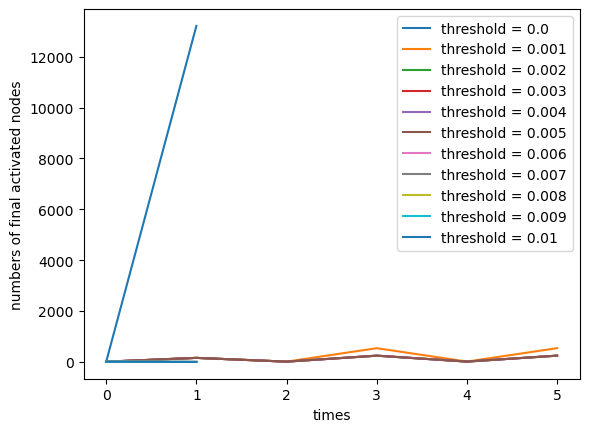

In [129]:
thresholds = np.arange(0,11)/1000
res_act = {}
res_fina = {}
res_times = {}
for th in thresholds:
    #g = init_threshold(th)
    res_fina[th], res_times[th] = lt_model.diffusion_all(init_seed, th)
for key, value in res_times.items():
    plt.plot(np.arange(len(value)), value, label="threshold = "+str(key))
plt.legend()
plt.xlabel("times")
plt.ylabel("numbers of final activated nodes")
plt.show()

### Compare the final activated nodes' number as a function of thresholds

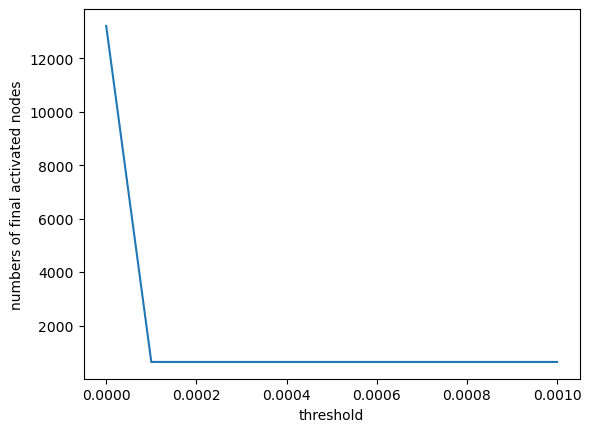

In [119]:
number_activated_nodes = [value for key, value in res_fina.items()]
plt.plot(res_fina.keys(), [len(value) for _, value in res_fina.items()])
plt.xlabel("threshold")
plt.ylabel("numbers of final activated nodes")
plt.show()